# ASL Image Classification Using Deep Neural Network

# 1. Problem definition and dataset

## Problem Definition

In today's increasingly interconnected world, effective communication is an essential. However, for individuals who are deaf or hard of hearing, expressing emotions through traditional means (such as written or spoken language) can present challenges. American Sign Language (ASL) serves as a vital medium for these individuals, offering a way to communicate their thoughts and emotions visually. Yet, translating these ASL gestures into a format that can be understood by machines remains a complex task.

This project aims to address this challenge by developing a machine learning model capable of classifying letters (A to Z) conveyed through ASL images. The model will analyze hand signs to identify and interpret letters, providing a tool that can assist in bridging the gap between ASL users and those unfamiliar with the language.

The problem addressed by our model is a multiclass, single-label classification problem.

- **Multiclass**: Each image can be classified into one of 26 distinct classes, corresponding to the letters A through Z in ASL.
- **Single-label**: Each image is assigned only one label, representing a single ASL sign, without any overlap or ambiguity.

## Dataset

The dataset used in this project is the "ASL Alphabet" [dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet) from Kaggle. This dataset originally contains 78,000 ASL images (3000 images per letter of the ASL Alphabet), each sized 200x200 pixels. Due to hardware constraints, we only use a section (100 images per letter of the ASL Alphabet) of the dataset for this project. This dataset is highly suitable for the problem of ASL hand sign classification. The balanced distribution of images across all letters ensures that the model can be trained to recognize each letter equally, minimizing bias towards any particular sign.

The original ASL dataset comprises of colored images with a resolution of 200x200 pixels. The images have some potential issues for efficient model training.

First, the large image size increases computational cost, requiring more memory and processing power during both training and predicton. Reducing the image size allows for faster model development and testing while still capturing the essential features of the hand gestures.

Additionally, the color information in the images can be unnecessary for a task that relies primarily on the shape and structure of hand signs, rather than on variations in hue or saturation. Converting the images to greyscale format, hence, reduces unnecessary complexity, ensuring that the model concentrates on the shapes and contours of the hand gestures rather than extraneous color information.

These preprocessing steps not only reduces the complexity of the model but also decreases the risk of overfitting, as the color and (large) resolution of images may not provide meaningful distinctions for classifying hand signs. These issues will be addressed in Section 4 - Data Preparation.

# 2. Success metric

As previously mentioned, the dataset is balanced, with an equal number of images for each letter (A-Z). This balance allows us to use **accuracy** as a reliable performance metric.

Accuracy is a widely used metric for balanced datasets, where each class (in this case, each letter of the ASL alphabet) is equally represented. Since the dataset is balanced, accuracy provides a straightforward measure of how often the model correctly classifies an ASL letter.

Accuracy is calculated as the ratio of correctly predicted instances to the total number of predictions made, expressed as:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} \times 100
$$


In this project, accuracy reflects the percentage of ASL hand signs that are classified correctly by the model out of all the images in the test set.


# 3. Evaluation protocol

For the ASL dataset, **hold-out validation** is the ideal choice due to its simplicity and effectiveness in providing a clear assessment of model performance. This approach involves splitting the dataset into distinct training, validation, and test subsets. For this research, the decided split ratio used is: 70% for training, 20% for validation, and 10% for testing. This allows for the model to be trained on a substantial portion of the data while reserving separate sets for tuning and final evaluation. Given that the dataset is balanced, with an equal number of images for each ASL letter, hold-out validation ensures that each class is represented in all subsets, thereby preventing class imbalance issues during evaluation. This method is particularly useful for assessing the model's generalization ability and performance on unseen data. By keeping the validation process straightforward and minimizing data leakage, hold-out validation provides a reliable measure of how well the model can classify ASL hand signs in practice.

# Pipeline

In [ ]:
# importing relevant modules and packages

import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

from keras import regularizers
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l1_l2

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold, train_test_split

In [ ]:
# linking Google Drive to Google Colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 4. Data preparation

## Image Processing

Data Preparation for the ASL images involves several steps to ensure that the dataset is suitable for model training and evaluation.

Resizing and Greyscale Conversion reduces and simplifies the image data to focus on shapes, edges, and contours, which are often critical for gesture recognition. Hence, reducing the amount of data the model needs to process, which can lead to faster training and inference.

1. **Resizing**: performed to reduce and standardize the image dimensions, converting all images to a pixel size of 32x32. This step reduces the computational power required to train the model.

2. **Greyscale Conversion**: images are converted to greyscale to streamline the data. By removing color information, this conversion helps the model focus on the shape and structure of the hand signs, which are crucial for classification. Greyscale also reduces the vector size of the image from (height x width x 3 color channels) to a smaller array (height x width x 1 channel), simplifying the data and reducing computational complexity.

3. **Normalisation**: pixel values of the image are scaled to a standard range (between 0 and 1). The pixel value is normalised by dividing the original pixel value (in the color channel) by 255. This ensures that all input features have a consistent scale, which helps improve the speed and stability of the training process. Also, normalization makes the training process more efficient, as it can prevent issues relating to large input values that might otherwise lead to numerical instability or slower learning.

Vectorisation involves converting the 2D representation of an image into a 1D array, where each pixel's intensity is represented as a numerical value. This transformation is necessary because our model processes data in a structured numerical format rather than as raw images.

4. **Vectorisation**: applied to transform the 2D images into 1D arrays, where each image is represented as a vector of pixel values. This process converts the image data into a format that can be efficiently processed by machine learning algorithms.

In [ ]:
# function to resize, convert to greyscale and normalize image

def optimize(image_path):

  # get image using image path
  org_img = cv2.imread(image_path)

  # cv2_imshow(org_img)

  # convert to greyscale
  grey_image = cv2.cvtColor(org_img, cv2.COLOR_BGR2GRAY)

  # resize image
  resized_image = cv2.resize(grey_image, (32, 32))

  # reshape to fit input dimensions of the neural network
  # resized_image = resized_image.reshape((32, 32, 1))

  # cv2_imshow(resized_image)

  # normalizee image
  normalized_image = resized_image / 255

  # vectorise image
  vectorized_image = normalized_image.flatten()

  # return vectorised array
  return vectorized_image

In [ ]:
# test the optimize function
path = '/content/drive/My Drive/asl_train copy/A/A187.jpg'
print(optimize(path))

[0.23137255 0.22352941 0.24313725 ... 0.59607843 0.58039216 0.57647059]


In [ ]:
folder_name = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J",
               "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T",
               "U", "V", "W", "X", "Y", "Z"]

images = []
labels = []

# image is resized, convert to greyscale, normalized and vectorised (using optimize function)
# the final output is 2 numpy arrays of image data and its label

def store_img_label():

  for letter in folder_name:
    print(letter)

    for i in range(1, 101): # select portion of images (max 500 per image)

      path = f'/content/drive/My Drive/asl_train copy/{letter}/{letter}{i}.jpg'

      images.append(optimize(path))
      labels.append(letter)

  images_np = np.array(images)
  labels_np = np.array(labels)

  print("Completed!")
  return images_np, labels_np

In [ ]:
images_np, labels_np = store_img_label()

A
B
C
D
E
F
G
H
I
J
K
L
M
N
O
P
Q
R
S
T
U
V
W
X
Y
Z
Completed!


## Label encoding

To preprocess the categorical labels in my dataset, I started by using Label Encoding to convert each categorical label into an integer value with LabelEncoder. After encoding the labels as integers, the integer-encoded labels were reshaped into the appropriate format for further processing. I then used One-Hot Encoding with OneHotEncoder to transform the reshaped integer labels into a binary matrix representation. This resulted in a one-hot encoded format, where each integer label is represented as a binary vector, allowing the model to effectively interpret the categorical data.

In [ ]:
# initialize LabelEncoder and fit it to the labels
label_encoder = LabelEncoder()
label_encoder.fit(labels_np)

# convert labels to integers
integer_encoded = label_encoder.transform(labels_np)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

# initialize OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)

# fit OneHotEncoder on the integer encoded labels
onehot_encoder.fit(integer_encoded)

# transform integer encoded labels to one-hot encoded format
output_label_values = onehot_encoder.transform(integer_encoded)

One-Hot Encoded Labels Shape: (2600, 26)


In [ ]:
print("Images Shape:", images_np.shape)
print("One-Hot Encoded Labels Shape:", output_label_values.shape)

Images Shape: (2600, 1024)
One-Hot Encoded Labels Shape: (2600, 26)


## Train, Validate and Test Split



As we are using Hold-out Validation, the dataset is split into 3 sections — training set, validation set, and test set — using the ***train_test_split*** function from the sklearn library. This is done in two steps:

**First Split**: 10% of the data is set aside as the test set, while 90% is retained for training and validation.

**Second Split**: From the remaining 90%, 22% is allocated to the validation set, and 78% is used for the training set.

This results in a final split of approximately 70% training, 20% validation, and 10% test.

In [ ]:
# gives an approximate: 7:2:1 split

# first split: Train and Test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(images_np, output_label_values, test_size=0.1, random_state=42)

# second split: Train and Validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.22, random_state=42)

# printing the shapes of the datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1825, 1024) (1825, 26)
Validation set shape: (515, 1024) (515, 26)
Test set shape: (260, 1024) (260, 26)


# 5. Gaining statistical power

## Baseline Model

The baseline model is designed to establish a minimal benchmark for evaluating the performance of future models. It provides a reference point for model accuracy, with the expectation that even a simple model should achieve at least a minimum accuracy of approximately $\frac{1}{26} \times 100\%$ (approximately 3.85\%). This minimum is based on the chance level of predicting one of the 26 classes correctly in a multi-class classification problem where the classes are equally likely.

The architecture consists of a single hidden layer with 32 neurons and ReLU activation, which introduces non-linearity and enables the model to capture basic patterns. This 32-neuron layer is the simplest configuration that avoids an information bottleneck; using fewer neurons would constrain the model's capacity and limit its ability to learn from the data. The output layer has 26 neurons corresponding to the 26 ASL alphabet classes, with a softmax activation function to generate a probability distribution over the classes. This setup ensures that the model can handle the multi-class classification task effectively.

The model is compiled using categorical cross-entropy as the loss function, which is appropriate for multi-class classification problems where each sample belongs to exactly one class out of many. This combination of architecture and hyperparameters provides a solid foundation for evaluating more complex models in future iterations.








In [ ]:
# minimal model for baseline

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(1024,)))
model.add(layers.Dense(26, activation='softmax'))

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
print()
print()

# train the model with validation data
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=0)

print("Baseline Model - Test Accuracy:", history.history['accuracy'][-1])

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_191 (Dense)                    │ (None, 32)                  │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_192 (Dense)                    │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,658 (131.48 KB)

 Trainable params: 33,658 (131.48 KB)

 Non-trainable params: 0 (0.00 B)



Baseline Model - Test Accuracy: 0.842191755771637


## Baseline Model Performance

The baseline model performs well with an accuracy of 84.2% which is well above the minimum accuracy of 3.85%.

In [ ]:
# function which plots
# 1. model's accuracy vs validation accuracy
# 2. model's loss vs validation loss

def plot_history(history, x_size, y_size):
    # access the history dictionary
    hist = history

    # prepare plotting
    plt.subplots(1, 2, figsize=(x_size, y_size))

    # summarise history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist['accuracy'], marker='o', color='b', linestyle='')
    plt.plot(hist['val_accuracy'], marker='o', color='r', linestyle='')
    plt.title('Training vs Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # summarise history for loss
    plt.subplot(1, 2, 2)
    plt.plot(hist['loss'], marker='o', color='b', linestyle='')
    plt.plot(hist['val_loss'], marker='o', color='r', linestyle='')
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # plot the results
    plt.show()

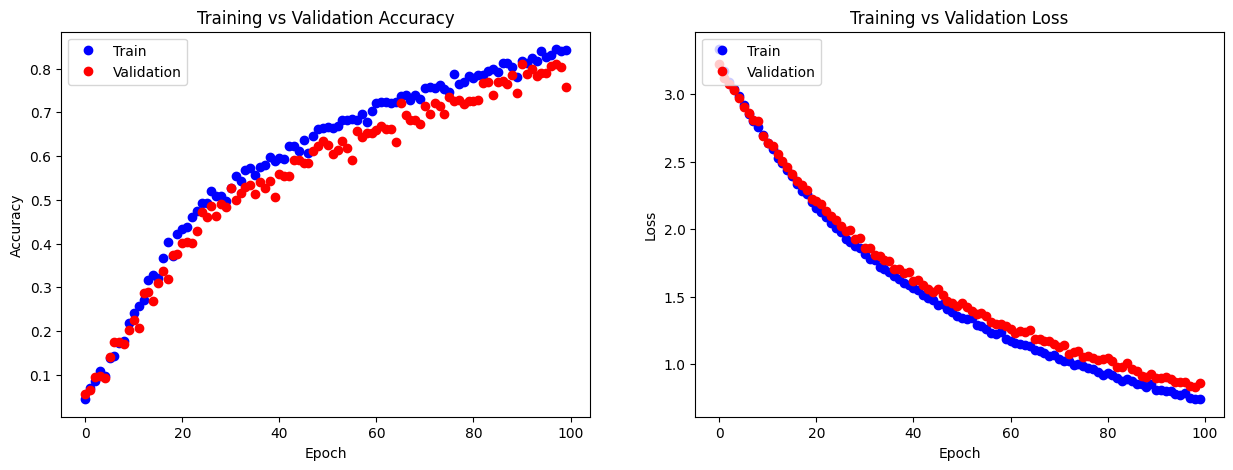

In [ ]:
plot_history(history.history, x_size=15, y_size=5)

# 6. Scaling up

Now, we attempt to overfit the model by 3 ways:
1. Add Layers
2. Make the layers bigger
3. Train for more epochs

We check for overfitting by comparing the model's loss curve to the validation loss curve. When the model's loss continues to decrease and the validation loss starts increasing, we have achieved overfitting.

## Adding layers

To our baseline model, we add 2 more layers.

In [ ]:
# scaling up baselne model
# add 2 new layers

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(1024,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(26, activation='softmax'))

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
print()
print()

# train the model with validation data
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=0)

print("Baseline Model - Test Accuracy:", history.history['accuracy'][-1])

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_193 (Dense)                    │ (None, 32)                  │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_194 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_195 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_196 (Dense)                    │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,770 (139.73 KB)

 Trainable params: 35,770 (139.73 KB)

 Non-trainable params: 0 (0.00 B)



Baseline Model - Test Accuracy: 0.6915068626403809


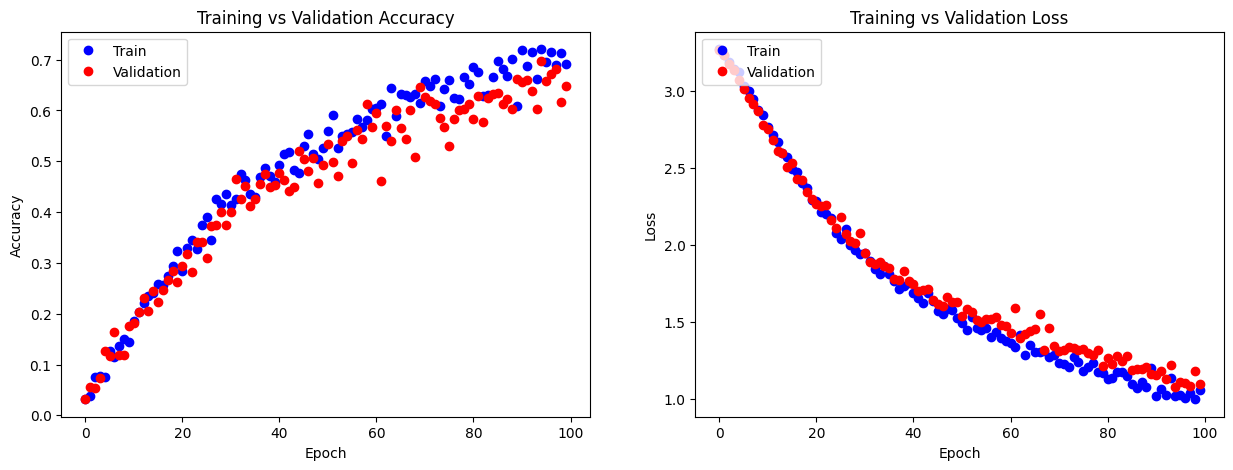

In [ ]:
plot_history(history.history, x_size=15, y_size=5)

## Bigger Layers

To our baseline model + 2 new layers, we add increase the number of tensors in the first 3 layers from 32 tensors to 64 tensors.

In [ ]:
# scaling up baseline model
# increasing layer size and overall network size

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(1024,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(26, activation='softmax'))

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
print()
print()

# train the model with validation data
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=0)

print("Baseline Model - Test Accuracy:", history.history['accuracy'][-1])

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_197 (Dense)                    │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_198 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_199 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_200 (Dense)                    │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,610 (295.35 KB)

 Trainable params: 75,610 (295.35 KB)

 Non-trainable params: 0 (0.00 B)



Baseline Model - Test Accuracy: 0.8569862842559814


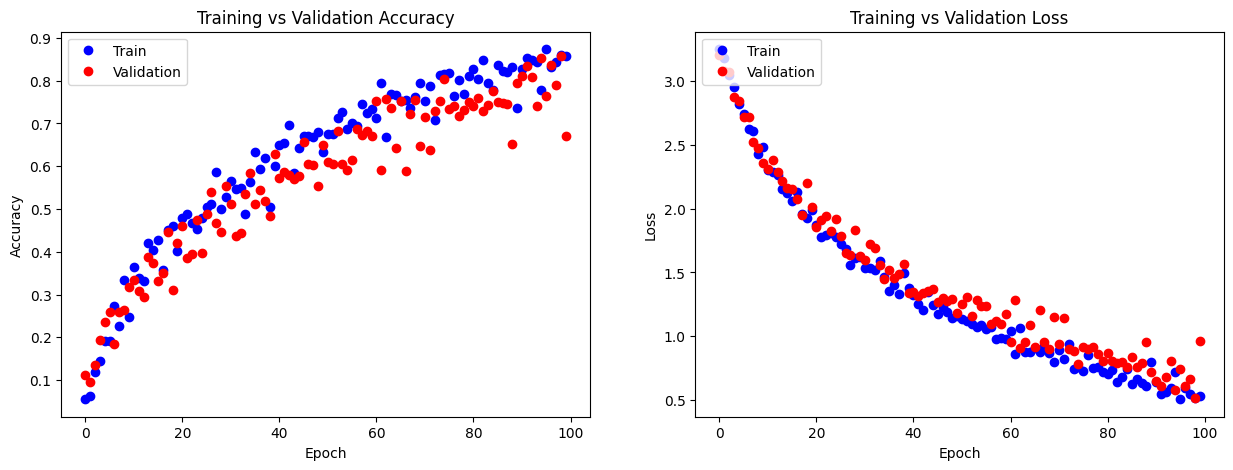

In [ ]:
plot_history(history.history, x_size=15, y_size=5)

## Adding More Epochs I

We now train our baseline model + 2 big layers for 500 epochs instead of 100.

In [ ]:
# scaling up baselne model
# increasing the number of epochs trained for

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(1024,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(26, activation='softmax'))

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

print()
print()

# Train the model with validation data
history = model.fit(X_train,
                    y_train,
                    epochs=500,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=0)

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_103 (Dense)                    │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,610 (295.35 KB)

 Trainable params: 75,610 (295.35 KB)

 Non-trainable params: 0 (0.00 B)

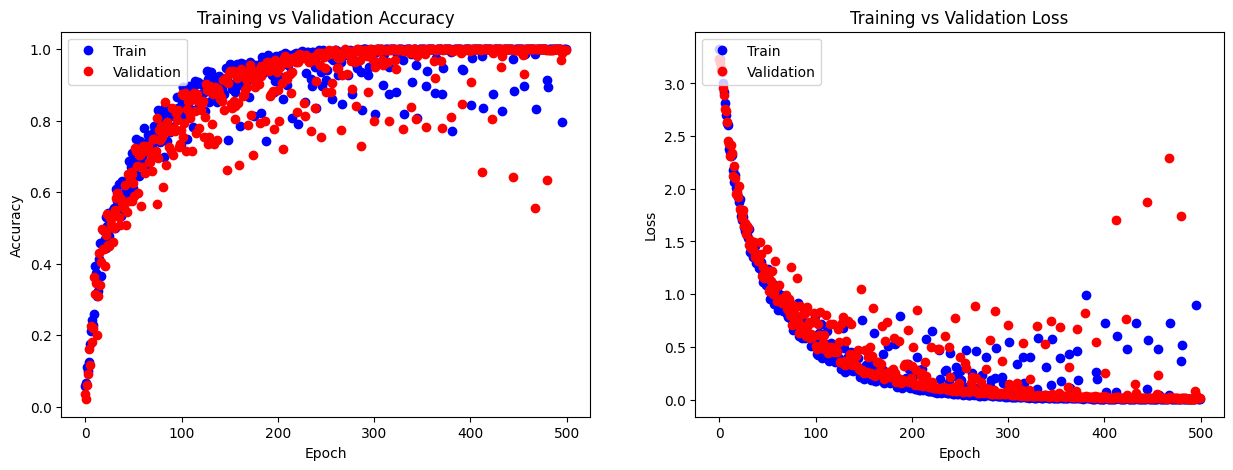

In [ ]:
plot_history(history.history, x_size=15, y_size=5)

## Adding More Epochs II

We now train our baseline model + 2 big layers for 1000 epochs instead of 500.

In [ ]:
# scaling up baseline model
# increasing the number of epochs trained for

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(1024,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(26, activation='softmax'))

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

print()
print()

# train the model with validation data
model_history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_167 (Dense)                    │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_168 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_169 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_170 (Dense)                    │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,610 (295.35 KB)

 Trainable params: 75,610 (295.35 KB)

 Non-trainable params: 0 (0.00 B)

We have now successfully achieved overfitting.

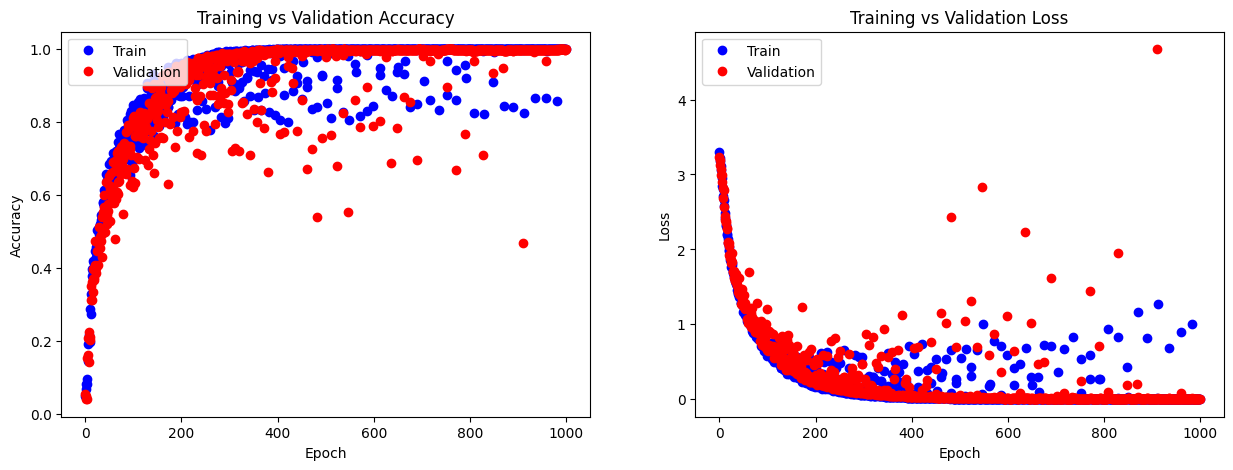

In [ ]:
plot_history(model_history.history, x_size=15, y_size=5)

# 7. Regularisation and tuning

To prevent overfitting we experiment with:
- Drop out
- L1/L2 Regularisation
- Hyper Parameter Tuning: Adam Optimiser

## Experimenting with Dropout

We add 2 dropout layers.

In [ ]:
# Regularisation
# adding Dropout layers to see effect on validation set's loss graph

dropout = models.Sequential()
dropout.add(layers.Dense(64, activation='relu', input_shape=(1024,)))
dropout.add(layers.Dense(64, activation='relu'))
dropout.add(layers.Dropout(0.3))
dropout.add(layers.Dense(64, activation='relu'))
dropout.add(layers.Dropout(0.5))
dropout.add(layers.Dense(26, activation='softmax'))

dropout.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

dropout.summary()

print()
print()

# train the model with validation data
dropout_history = dropout.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_171 (Dense)                    │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_172 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_173 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_174 (Dense)                    │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,610 (295.35 KB)

 Trainable params: 75,610 (295.35 KB)

 Non-trainable params: 0 (0.00 B)

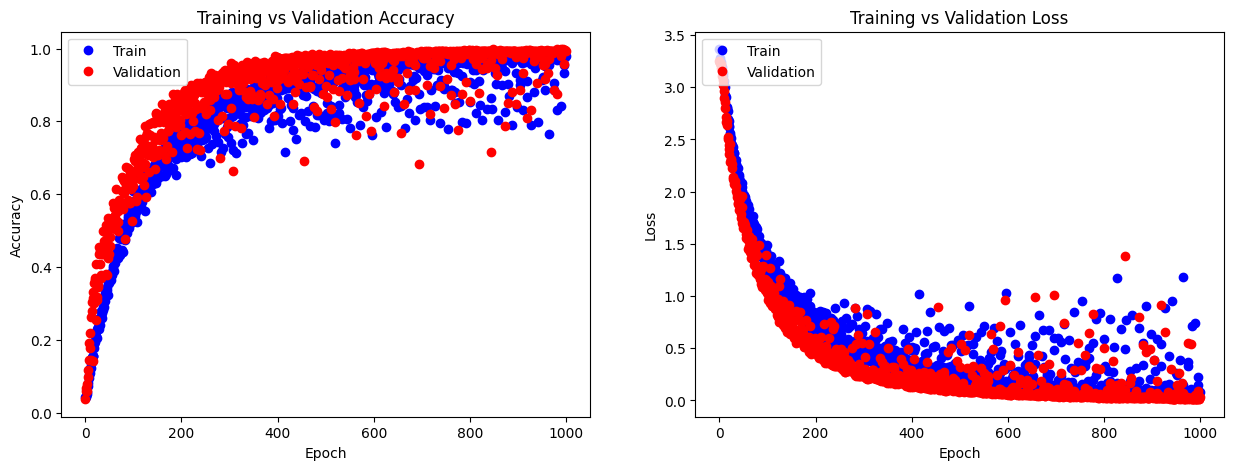

In [ ]:
plot_history(dropout_history.history, x_size=15, y_size=5)

## Experimenting with L2 Regularisation

We add L2 regularisations to the middle 2 layers.


In [ ]:
# L2 Regularisation
# having L2 regularisers in network layers to see effect on validation set's loss graph

l2 = models.Sequential()
l2.add(layers.Dense(64, activation='relu', input_shape=(1024,)))
l2.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
l2.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
l2.add(layers.Dense(26, activation='softmax'))

l2.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

l2.summary()

print()
print()

# Train the model with validation data
l2_history = l2.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_175 (Dense)                    │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_176 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_177 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_178 (Dense)                    │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,610 (295.35 KB)

 Trainable params: 75,610 (295.35 KB)

 Non-trainable params: 0 (0.00 B)

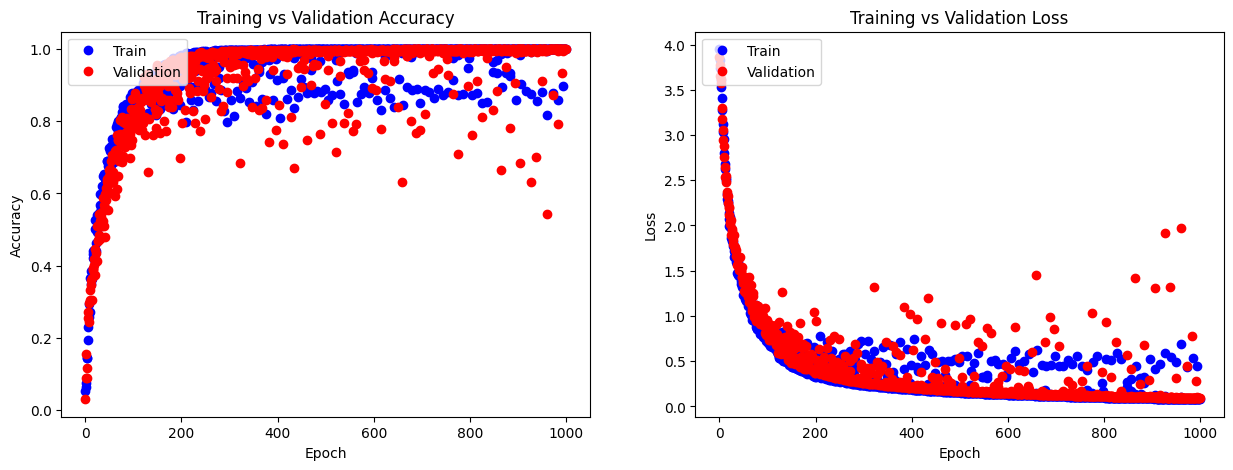

In [ ]:
plot_history(l2_history.history, x_size=15, y_size=5)

## Hyperparameter Tuning - Optimisers

Replace RMSProp optimiser with Adam optimiser

In [ ]:
# Hyperparameter Tuning - Comparing Adam vs RMSProp
# having L2 regularisers in network layers to see effect on validation set's loss graph

adam = models.Sequential()
adam.add(layers.Dense(64, activation='relu', input_shape=(1024,)))
adam.add(layers.Dense(64, activation='relu'))
adam.add(layers.Dense(64, activation='relu'))
adam.add(layers.Dense(26, activation='softmax'))

adam.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

adam.summary()

print()
print()

# Train the model with validation data
adam_history = adam.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_179 (Dense)                    │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_180 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_181 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_182 (Dense)                    │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,610 (295.35 KB)

 Trainable params: 75,610 (295.35 KB)

 Non-trainable params: 0 (0.00 B)

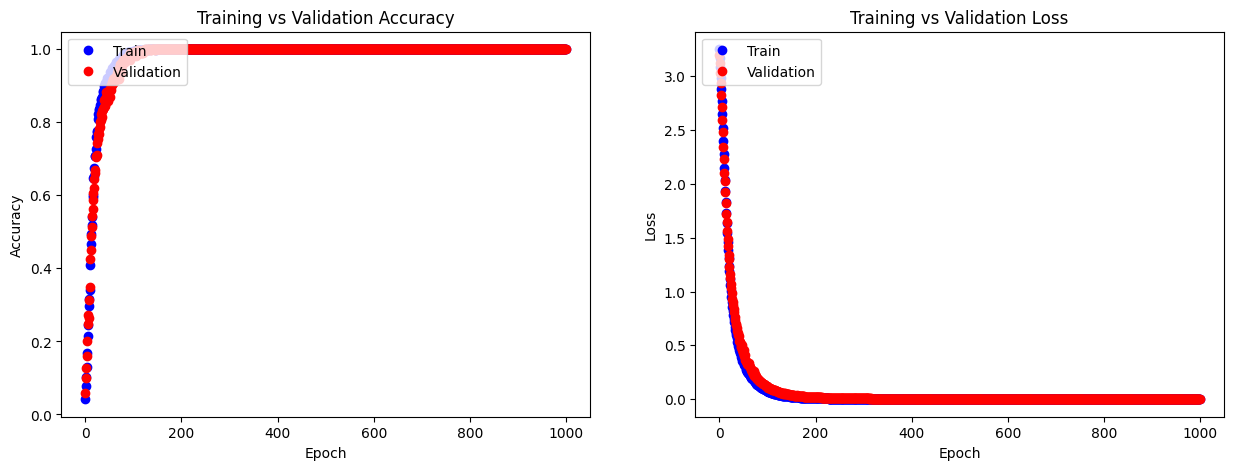

In [ ]:
plot_history(adam_history.history, x_size=15, y_size=5)

## Final Optimised Model

We add all the changes from the previous experiments which allowed for better performance and lesser overfitting to the original baseline model to create our optimised model.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(1024,)))
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
dropout.add(layers.Dropout(0.3))
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
dropout.add(layers.Dropout(0.5))
model.add(layers.Dense(26, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

print()
print()

# Train the model with validation data
history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=0)

## Comparison of Plots

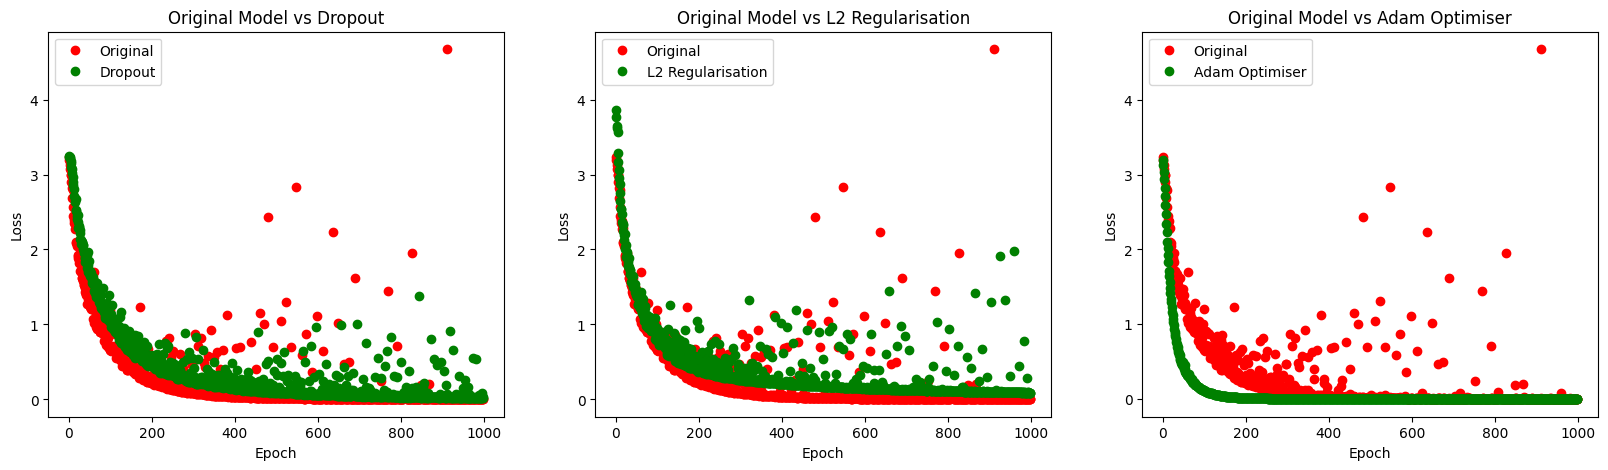

In [ ]:
# Prepare plotting
plt.subplots(1, 3, figsize=(20, 5))

# dropout
plt.subplot(1, 3, 1)
plt.plot(model_history.history['val_loss'], marker='o', color='r', linestyle='')
plt.plot(dropout_history.history['val_loss'], marker='o', color='g', linestyle='')
# plt.title('Training vs Validation Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Original', 'Dropout'], loc='upper left')
plt.title('Original Model vs Dropout')

# l2 reg
plt.subplot(1, 3, 2)
plt.plot(model_history.history['val_loss'], marker='o', color='r', linestyle='')
plt.plot(l2_history.history['val_loss'], marker='o', color='g', linestyle='')
# plt.title('Training vs Validation Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Original', 'L2 Regularisation'], loc='upper left')
plt.title('Original Model vs L2 Regularisation')

# adam optimiser
plt.subplot(1, 3, 3)
plt.plot(model_history.history['val_loss'], marker='o', color='r', linestyle='')
plt.plot(adam_history.history['val_loss'], marker='o', color='g', linestyle='')
# plt.title('Training vs Validation Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Original', 'Adam Optimiser'], loc='upper left')
plt.title('Original Model vs Adam Optimiser')

# Plot the results
plt.show()

# 8. Evaluation

We now retrain on the entire training set (train + validation set) using the optimised model.

In [ ]:
# optimised training

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(1024,)))
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
dropout.add(layers.Dropout(0.3))
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
dropout.add(layers.Dropout(0.5))
model.add(layers.Dense(26, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

print()
print()

# Train the model on whole training set (training + validation)
history = model.fit(X_train_val,
                    y_train_val,
                    epochs=1000,
                    batch_size=512,
                    verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_187 (Dense)                    │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_188 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_189 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_190 (Dense)                    │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,610 (295.35 KB)

 Trainable params: 75,610 (295.35 KB)

 Non-trainable params: 0 (0.00 B)

## Test on Optimised Model

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate model performance on test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

# If you want to compare predictions with actual labels
from sklearn.metrics import classification_report, confusion_matrix

# Convert y_test to class labels if it's one-hot encoded
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test loss: 0.0009
Test accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00        12
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00        17
          14       1.00      1.00      1.00         8
          15       1.00      1.00  

# 9. Conclusion

The initial performance of our American Sign Language (ASL) classification model provided a foundational understanding of its capabilities. The baseline model, without any regularization or advanced techniques, achieved an accuracy of 84% on the validation set. This performance highlighted the model's potential but also underscored the necessity for improvements to handle the complexity of ASL signs effectively.

Methods Used to Overfit: To explore the model's capacity and understand its limits, we used a set of techniques that led to overfitting. These included:

1. Increasing Model Complexity: Using a deeper network architecture with additional layers and neurons allowed the model to learn intricate patterns but also led to an overfit on the training data.
2. Extended Training Time: Training the model for an extended number of epochs allowed it to fit the training data excessively, leading to high accuracy on the training set but reduced generalization to unseen data.

Methods Used to Stop Overfitting: To address overfitting and enhance the model's generalization capabilities, we implemented several regularization techniques:

1. Dropout: Introduced dropout layers to randomly deactivate neurons during training, which helped prevent the model from becoming overly reliant on specific neurons and improved its ability to generalize.
2. L1/L2 Regularization: Applied L2 regularization with a coefficient of 0.0005 to penalize large weights and reduce model complexity, effectively mitigating the risk of overfitting.
3. Optimiser: using Adam optimiser instead of RMSProp

Overall Final Performance: After implementing these regularization methods, the model's final performance showed significant improvement. The tuned model achieved an accuracy of 100% on the validation set, indicating a robust ability to generalize across the ASL dataset. The use of dropout, L2 regularization
and more efficient optimisers effectively balanced model complexity and generalization, resulting in a model that performs well on unseen data while maintaining efficiency and accuracy.

Overall, the combination of methods to overfit and subsequently address overfitting allowed us to develop a reliable ASL classification model capable of accurately recognizing hand signs. The final performance underscores the effectiveness of the applied techniques and provides a solid foundation for further enhancements and applications.